In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv(r'./data.csv')

In [43]:
df.shape

(6819, 96)

In [44]:
df.dtypes

Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object

----
### Correlation

#### Dropping

In [45]:
def plot_cor(data):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr))
    ax = sns.heatmap(
        corr, mask=mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

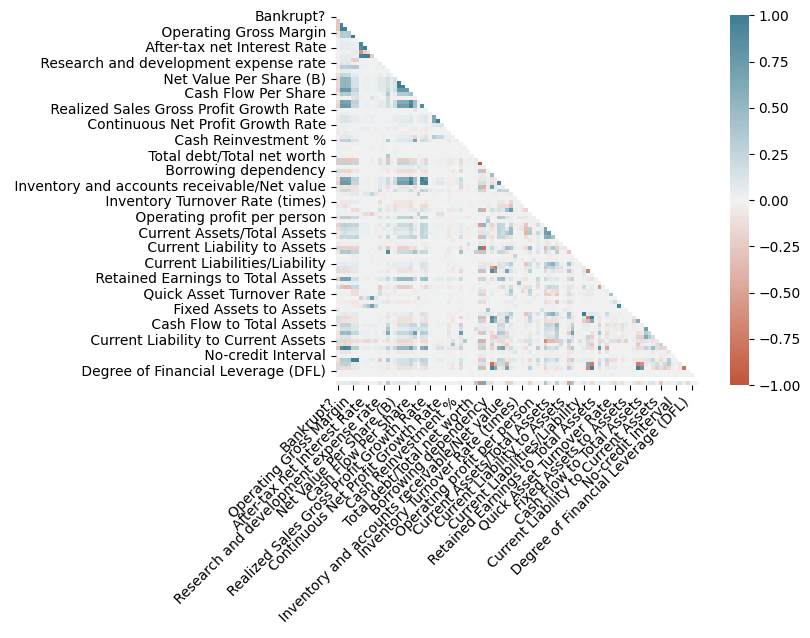

In [46]:
plot_cor(df)

In [47]:
def drop_cor(df, trsh):
	# Create correlation matrix
	corr_matrix = df.corr().abs()
	
	# Select upper triangle of correlation matrix
	upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
								k=1).astype(bool))
	
	# Find features with correlation greater than 0.95
	to_drop = [column for column in upper.columns if any(upper[column] > trsh)]
	
	# Drop features 
	df.drop(to_drop, axis=1, inplace=True)

In [48]:
drop_cor(df, 0.8)

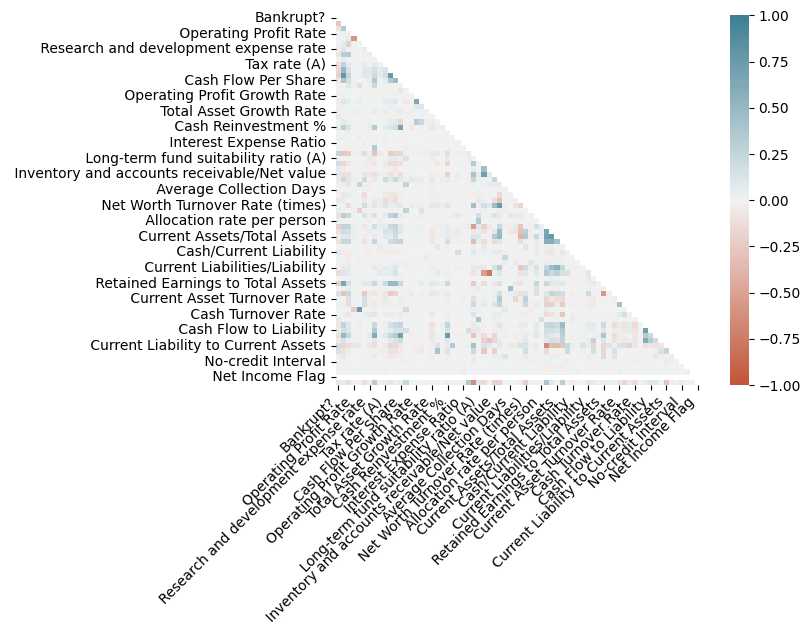

In [49]:
plot_cor(df)

In [50]:
df.shape

(6819, 71)

In [51]:
# from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [52]:
# constant_filter = VarianceThreshold(threshold=0)
# constant_filter.fit(train_features)
# train_features = constant_filter.transform(train_features)
# test_features = constant_filter.transform(test_features)
# train_features.shape, test_features.shape


In [53]:
X = df.drop(['Bankrupt?'], axis = 1)
y = df['Bankrupt?']

----
### Feature Selection

Figure out most important features:

In [54]:
SFM = SelectFromModel(estimator=RandomForestClassifier())
sel = SFM.fit(X, y)
selected_feat= X.columns[(sel.get_support())]
print(selected_feat)

Index([' ROA(C) before interest and depreciation before interest',
       ' Non-industry income and expenditure/revenue',
       ' Interest-bearing debt interest rate', ' Net Value Per Share (B)',
       ' Persistent EPS in the Last Four Seasons', ' Net Value Growth Rate',
       ' Quick Ratio', ' Interest Expense Ratio',
       ' Total debt/Total net worth', ' Debt ratio %', ' Borrowing dependency',
       ' Accounts Receivable Turnover', ' Operating profit per person',
       ' Cash/Total Assets', ' Cash/Current Liability',
       ' Working Capital/Equity', ' Retained Earnings to Total Assets',
       ' Total income/Total expense', ' Degree of Financial Leverage (DFL)',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Equity to Liability'],
      dtype='object')


In [55]:
feature_scores = pd.Series(sel.estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)

print(feature_scores)

 Net Value Growth Rate                          0.045900
 Persistent EPS in the Last Four Seasons        0.039324
 Debt ratio %                                   0.031579
 Borrowing dependency                           0.030901
 Non-industry income and expenditure/revenue    0.028487
                                                  ...   
 Cash Flow to Equity                            0.007017
 Contingent liabilities/Net worth               0.005660
 Tax rate (A)                                   0.003959
 Liability-Assets Flag                          0.000336
 Net Income Flag                                0.000000
Length: 70, dtype: float64


In [56]:
X = X.loc[: , selected_feat]

----
### Near Miss Undersampling

Do undersampling with NearMiss and split data set:

In [57]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

In [58]:
nm = NearMiss(version=1)
X_train_nm, y_train_nm= nm.fit_resample(X, y)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_train_nm, y_train_nm, test_size = .2, 
                                                            stratify = y_train_nm, random_state = 42)

Evaluation function:

In [60]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [61]:
def generate_results(y_labels, predictions, name):
    cl_rep = classification_report(y_labels, predictions)
    print("\nThe classification report for " + name + " is:", cl_rep, sep = "\n")
    cm_model = metrics.confusion_matrix(y_labels, predictions)
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm_model, annot = True, cmap = 'Greens', annot_kws = {'size': 15}, square = True)
    plt.title('Confusion Matrix for ' + name, size = 15)
    plt.xticks(size = 15)
    plt.yticks(size = 15)
    plt.show()

Now on to the models:

In [62]:
import warnings
warnings.filterwarnings("ignore")

----
### Voting Classifier

##### A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.

In [63]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Hard Voting Score  0.636364

The classification report for Hard Voting is:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        44
           1       1.00      0.27      0.43        44

    accuracy                           0.64        88
   macro avg       0.79      0.64      0.58        88
weighted avg       0.79      0.64      0.58        88



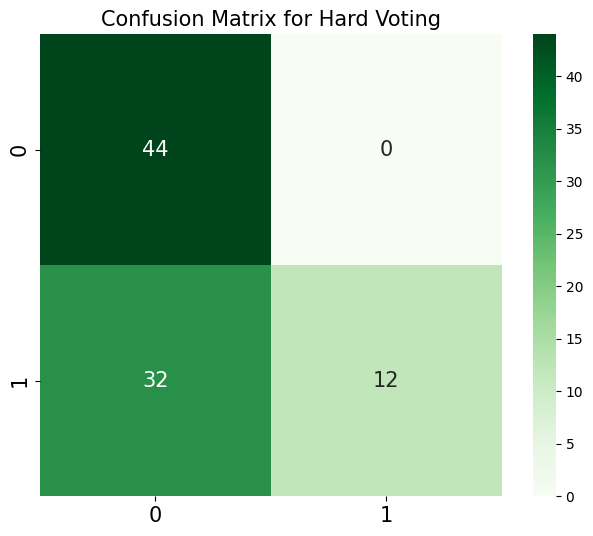

Soft Voting Score  0.761364

The classification report for Soft Voting is:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        44
           1       0.76      0.77      0.76        44

    accuracy                           0.76        88
   macro avg       0.76      0.76      0.76        88
weighted avg       0.76      0.76      0.76        88



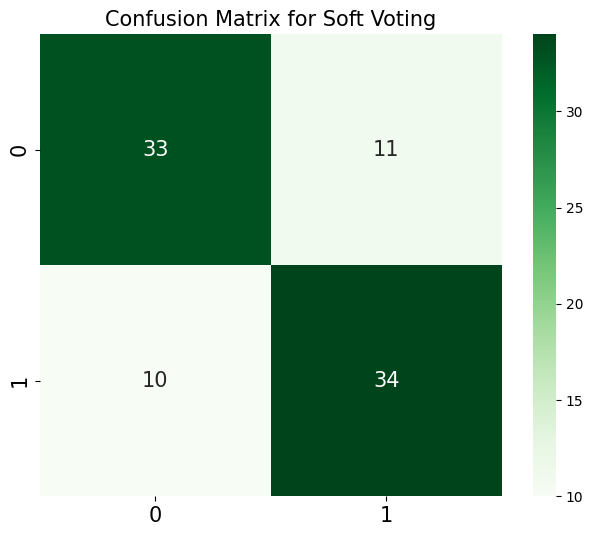

In [64]:
# group / ensemble of models
estimator = []
estimator.append(('LR', 
                  LogisticRegression(solver ='lbfgs', 
                                     multi_class ='multinomial')))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('DTC', DecisionTreeClassifier()))
  
# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)
  
# Looking at performance
score = accuracy_score(y_test, y_pred)
print("Hard Voting Score % f" % score)
generate_results(y_test, y_pred, "Hard Voting")

  
# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, y_train)
y_pred = vot_soft.predict(X_test)
  
# Look at performance
score = accuracy_score(y_test, y_pred)
print("Soft Voting Score % f" % score)
generate_results(y_test, y_pred, "Soft Voting")

Checking for the full dataset performance:

Hard Voting Score  0.629418

The classification report for Hard Voting is:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      6599
           1       0.02      0.20      0.03       220

    accuracy                           0.63      6819
   macro avg       0.49      0.42      0.40      6819
weighted avg       0.93      0.63      0.75      6819



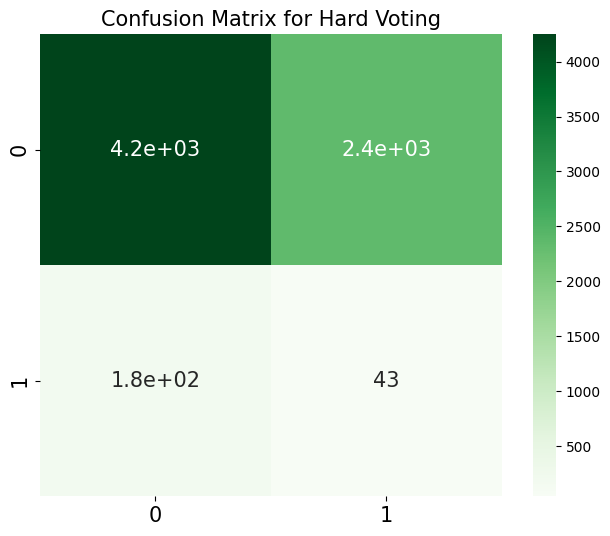

Soft Voting Score  0.385100

The classification report for Soft Voting is:
              precision    recall  f1-score   support

           0       1.00      0.37      0.54      6599
           1       0.05      0.95      0.09       220

    accuracy                           0.39      6819
   macro avg       0.52      0.66      0.31      6819
weighted avg       0.97      0.39      0.52      6819



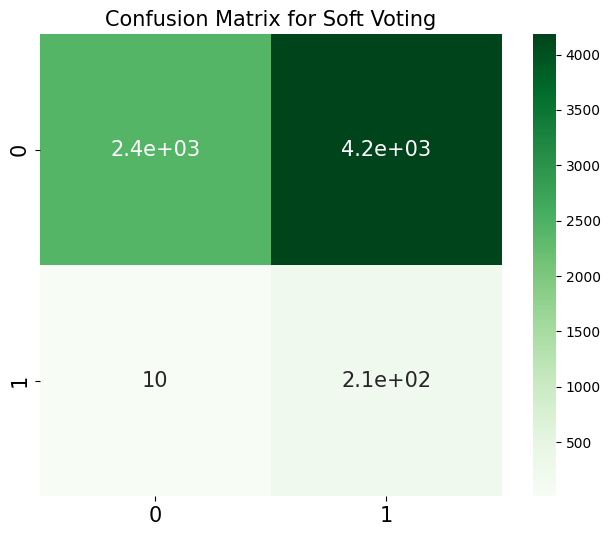

In [65]:
# Hard voting full set
y_pred = vot_hard.predict(X)
  
# Looking at performance
score = accuracy_score(y, y_pred)
print("Hard Voting Score % f" % score)
generate_results(y, y_pred, "Hard Voting")

# Soft voting full set
y_pred = vot_soft.predict(X)
  
# Look at performance
score = accuracy_score(y, y_pred)
print("Soft Voting Score % f" % score)
generate_results(y, y_pred, "Soft Voting")

----
### HistGradientBoostingClassifier

#### Like GB Classifier but faster and scales well with a lot of data

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

HGBC Score  0.840909

The classification report for HGBC is:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        44
           1       0.84      0.84      0.84        44

    accuracy                           0.84        88
   macro avg       0.84      0.84      0.84        88
weighted avg       0.84      0.84      0.84        88



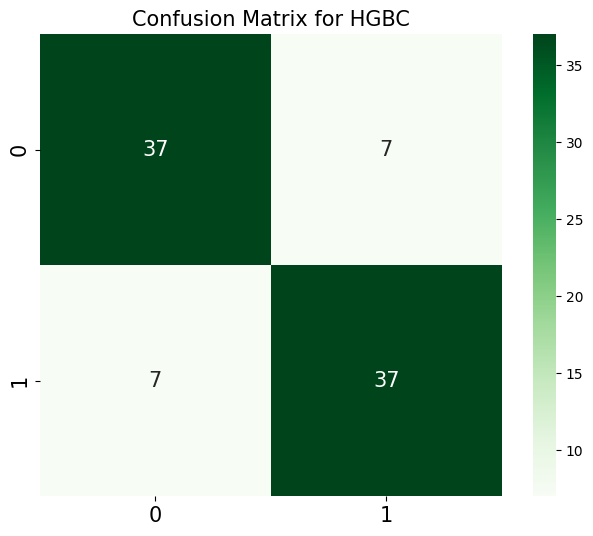

HGBC Score  0.369996

The classification report for HGBC is:
              precision    recall  f1-score   support

           0       1.00      0.35      0.52      6599
           1       0.05      0.97      0.09       220

    accuracy                           0.37      6819
   macro avg       0.52      0.66      0.30      6819
weighted avg       0.97      0.37      0.50      6819



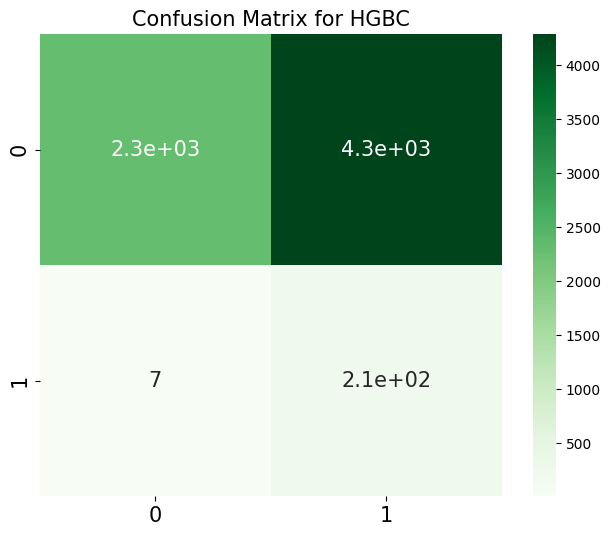

In [72]:
# fitting
classifier =  HistGradientBoostingClassifier()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

# Accuracy on undersampled
score = accuracy_score(y_test, y_pred)
print("HGBC Score % f" % score)
generate_results(y_test, y_pred, "HGBC")

# full set
y_pred = classifier.predict(X)
  
# Look at performance
score = accuracy_score(y, y_pred)
print("HGBC Score % f" % score)
generate_results(y, y_pred, "HGBC")


----
### Calibrated Classifier CV

#### Instead of predicting class values directly for a classification problem, it can be convenient to predict the probability of an observation belonging to each possible class.


When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. This probability gives you some kind of confidence on the prediction. Some models can give you poor estimates of the class probabilities and some even do not support probability prediction (e.g., some instances of SGDClassifier). The calibration module allows you to better calibrate the probabilities of a given model, or to add support for probability prediction.

Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.



In [66]:
from sklearn.calibration import CalibratedClassifierCV

HGBC Calibrated Score  0.806818

The classification report for HGBC Calibrated is:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81        44
           1       0.83      0.77      0.80        44

    accuracy                           0.81        88
   macro avg       0.81      0.81      0.81        88
weighted avg       0.81      0.81      0.81        88



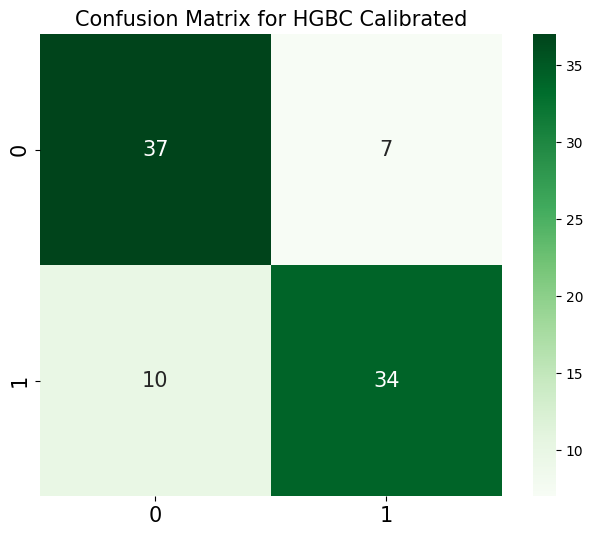

HGBC Calibrated Score  0.369996

The classification report for HGBC Calibrated is:
              precision    recall  f1-score   support

           0       1.00      0.35      0.52      6599
           1       0.05      0.97      0.09       220

    accuracy                           0.37      6819
   macro avg       0.52      0.66      0.30      6819
weighted avg       0.97      0.37      0.50      6819



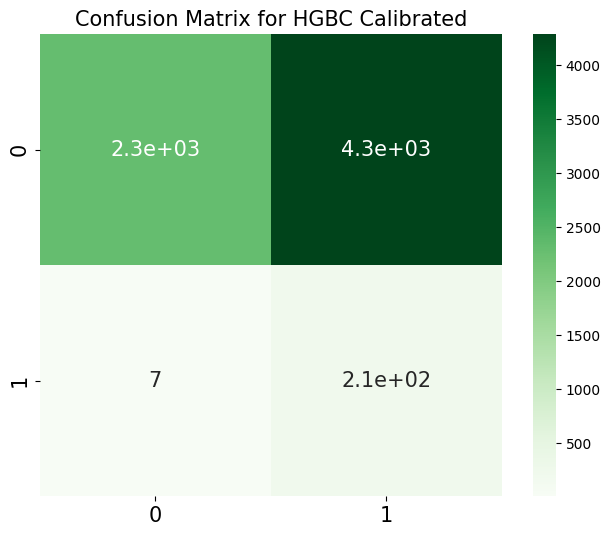

In [74]:
model = CalibratedClassifierCV(classifier, cv=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
  
# Looking at performance
score = accuracy_score(y_test, y_pred)
print("HGBC Calibrated Score % f" % score)
generate_results(y_test, y_pred, "HGBC Calibrated")


# full set
y_pred = classifier.predict(X)
  
# Look at performance
score = accuracy_score(y, y_pred)
print("HGBC Calibrated Score % f" % score)
generate_results(y, y_pred, "HGBC Calibrated")
